In [1]:
import numpy as np 
from PIL import Image, ImageDraw, ImageFont 
from skimage import transform as tf

In [2]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"bretan/Coval-Black.otf", 22) 
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    # Apply scale
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey))
    return image

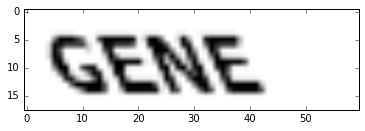

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

In [4]:
from skimage.measure import label, regionprops

In [5]:
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square

In [6]:
def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        # No subimages found, so return the entire image
        return [image,]
    return subimages

In [7]:
subimages = segment_image(image)

In [8]:
len(subimages)

4

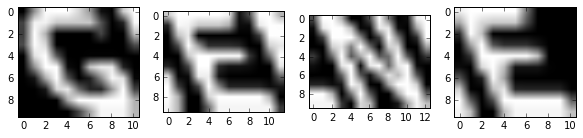

In [9]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

In [10]:
from sklearn.utils import check_random_state
random_state = check_random_state(14) 
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.8, 0.05)
scale_values = np.arange(0.9, 1.1, 0.1)

In [11]:
def generate_sample(random_state=None): 
    random_state = check_random_state(random_state) 
    letter = random_state.choice(letters) 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: L


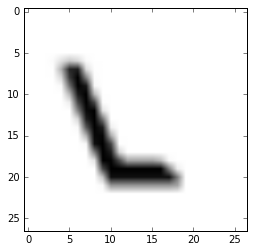

In [12]:
image, target = generate_sample(random_state) 
plt.imshow(image, cmap="Greys") 
print("The target for this image is: {0}".format(letters[target]))

In [13]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float') 
targets = np.array(targets)

In [14]:
from sklearn.preprocessing import OneHotEncoder 
onehot = OneHotEncoder() 
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [15]:
y = y.todense()

In [16]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [17]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

# Classification

In [18]:
from sklearn.neural_network import MLPClassifier

In [19]:
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14)

In [20]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import f1_score


f1_score(y_pred=y_pred, y_true=y_test, average='macro')

/home/robert/Programs/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/robert/Programs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/Programs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.92307692307692313

In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         6
          3       1.00      1.00      1.00         7
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         4
          8       1.00      1.00      1.00         4
          9       0.00      0.00      0.00         0
         10       1.00      1.00      1.00         6
         11       1.00      1.00      1.00         3
         12       1.00      1.00      1.00         5
         13       1.00      1.00      1.00         4
         14       1.00      1.00      1.00         6
         15       1.00      1.00      1.00         2
         16       1.00      1.00      1.00         3
         17       1.00      1.00      1.00   

/home/robert/Programs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/Programs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    dataset = np.array([tf.resize(subimage, (20, 20)) for subimage in subimages])
    X_test = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

    y_pred = neural_network.predict_proba(X_test)
    predictions = np.argmax(y_pred, axis=1)
    assert len(y_pred) == len(X_test)
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

In [24]:
clf.predict_proba

<bound method MLPClassifier.predict_proba of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=14, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)>

In [25]:
word = "GENE"
captcha = create_captcha(word, shear=0.2) 
print(predict_captcha(captcha, clf))

GENE


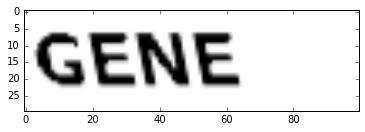

In [26]:
plt.imshow(captcha, cmap="Greys") 

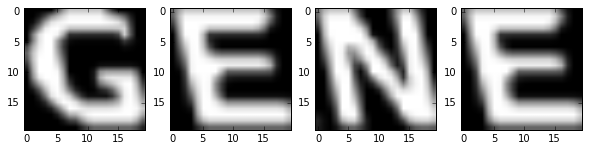

In [27]:
subimages = segment_image(captcha)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(tf.resize(subimages[i], (20,20)), cmap="gray")

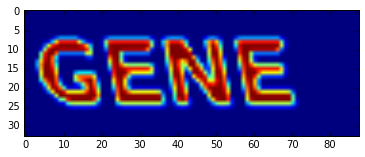

In [28]:
image = create_captcha(word, shear=0.2, scale=1.1, size=(len(word) * 20, 30))
plt.imshow(image)

In [29]:
def test_prediction(word, net, shear=0.2, scale=1):
    captcha = create_captcha(word, shear=shear, scale=scale, size=(len(word) * 20, 30))
    prediction = predict_captcha(captcha, net)
    return word == prediction, word, prediction

In [30]:
from nltk.corpus import words

In [31]:
valid_words = [word.upper() for word in words.words() if len(word) == 4]

In [32]:
if False:
    correct = 0
    incorrect = 0

    for word in valid_words:
        shear = random_state.choice(shear_values)
        scale = random_state.choice(scale_values)
        subimages = create_captcha(word, shear=shear, scale=scale, size=(30, len(word) * 25))

In [33]:
num_correct = 0 
num_incorrect = 0 
for word in valid_words: 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=shear, scale=scale)
    #print(correct, word, prediction)
    if correct: 
        num_correct += 1 
    else: 
        num_incorrect += 1
        #if len(prediction) == len(word):
        #    print(word, prediction)
print("Number correct is {0}".format(num_correct)) 
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 3446
Number incorrect is 2067


In [34]:
correct

True

In [35]:
p = num_correct/(num_correct+num_incorrect)
p

0.6250680210411754

In [36]:
0.99 ** 4

0.96059601

In [37]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm = np.array([row / np.sum(row) for row in cm])
np.fill_diagonal(cm, 0)
# cm = np.log(cm + 1e-16)

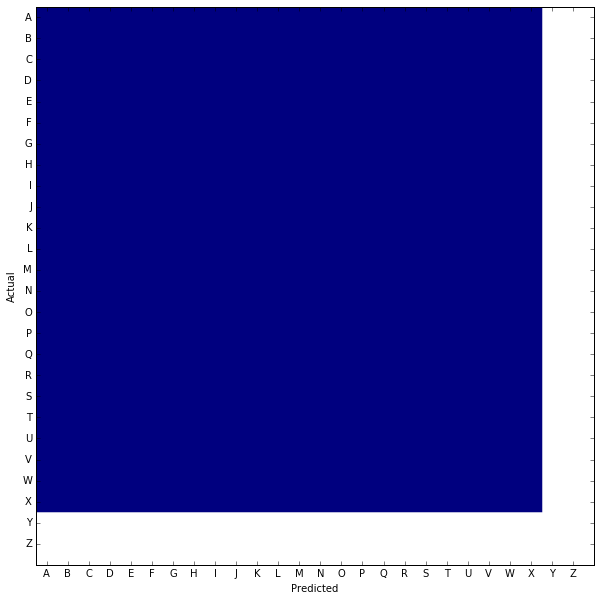

In [38]:
plt.figure(figsize=(10, 10)) 
plt.imshow(cm, interpolation='nearest')
tick_marks = np.arange(len(letters)+1)
plt.xticks(tick_marks, letters) 
plt.yticks(tick_marks, letters) 
plt.ylabel('Actual') 
plt.xlabel('Predicted')
plt.show()

In [39]:
from nltk.metrics import edit_distance 
steps = edit_distance("STEP", "STOP") 
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [40]:
def compute_distance(prediction, word):
    
    len_word = min(len(prediction), len(word))
    
    return len_word - sum([prediction[i] == word[i] for i in range(len_word)])

In [41]:
from operator import itemgetter 

def improved_prediction(word, net, dictionary, shear=0.2, scale=1.0): 
    captcha = create_captcha(word, shear=shear, scale=scale) 
    prediction = predict_captcha(captcha, net) 
    
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0] 
        prediction = best_word[0]
    return word == prediction, word, prediction

In [42]:
num_correct = 0 
num_incorrect = 0 
for word in valid_words: 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = improved_prediction(word, clf, valid_words, shear=shear, scale=scale)
    #print(correct, word, prediction)
    if correct: 
        num_correct += 1 
    else: 
        num_incorrect += 1
        #if len(prediction) == len(word):
        #    print(word, prediction)
print("Number correct is {0}".format(num_correct)) 
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 3945
Number incorrect is 1568


In [43]:
p = num_correct/(num_correct+num_incorrect)
p

0.7155813531652457